## Spatial Gaussian Processes: Inference and prediction

### Loading main packages

In [1]:
import CairoMakie: save, Figure, Axis
import CairoMakie
using Meshes, MeshViz
using AbstractGPs
using StatsFuns
using Optim

include(joinpath("..", "src", "meshes.jl"))

vizpp (generic function with 4 methods)

### Simulating spatial GPs

Define the Gaussian process with $\sigma^2 = 10 and \phi = 0.3$.

In [2]:
κ = 10 * Matern32Kernel() ∘ ScaleTransform(1 / 0.3)
W = GP(κ)

AbstractGPs.GP{AbstractGPs.ZeroMean{Float64}, KernelFunctions.TransformedKernel{KernelFunctions.ScaledKernel{KernelFunctions.Matern32Kernel{Distances.Euclidean}, Int64}, KernelFunctions.ScaleTransform{Float64}}}(AbstractGPs.ZeroMean{Float64}(), Matern 3/2 Kernel (metric = Distances.Euclidean(0.0))
	- σ² = 10
	- Scale Transform (s = 3.3333333333333335))

Define a number of location where observations are taken.

In [3]:
n = 400
D = Quadrangle((0, 0), (10, 0), (10, 10), (0, 10))
S = sample(D, HomogeneousSampling(n)) |> PointSet

400 PointSet{2,Float64}
  └─Point(2.490963157151298, 7.56757202075031)
  └─Point(0.27776323141746606, 0.35793046087259855)
  └─Point(4.32279474279457, 8.363669104573678)
  └─Point(4.506727976453759, 0.48907305306337134)
  └─Point(6.627187980496638, 0.1769482114431109)
  ⋮
  └─Point(1.4249914944834374, 2.8773555353629674)
  └─Point(0.9843860677555771, 1.8656910884804077)
  └─Point(1.1227734387336252, 6.305447761421759)
  └─Point(1.5019628004728691, 0.8506086747998309)
  └─Point(5.765791716223518, 0.278686259764368)

Define the random vector with respect of the locations and $\tau^2 = 1$

In [4]:
Y = W(coordinates.(S), 1)

AbstractGPs.FiniteGP{AbstractGPs.GP{AbstractGPs.ZeroMean{Float64}, KernelFunctions.TransformedKernel{KernelFunctions.ScaledKernel{KernelFunctions.Matern32Kernel{Distances.Euclidean}, Int64}, KernelFunctions.ScaleTransform{Float64}}}, Vector{Meshes.Vec2}, LinearAlgebra.Diagonal{Int64, FillArrays.Fill{Int64, 1, Tuple{Base.OneTo{Int64}}}}}(
f: AbstractGPs.GP{AbstractGPs.ZeroMean{Float64}, KernelFunctions.TransformedKernel{KernelFunctions.ScaledKernel{KernelFunctions.Matern32Kernel{Distances.Euclidean}, Int64}, KernelFunctions.ScaleTransform{Float64}}}(AbstractGPs.ZeroMean{Float64}(), Matern 3/2 Kernel (metric = Distances.Euclidean(0.0))
	- σ² = 10
	- Scale Transform (s = 3.3333333333333335))
x: Meshes.Vec2[[2.490963157151298, 7.56757202075031], [0.27776323141746606, 0.35793046087259855], [4.32279474279457, 8.363669104573678], [4.506727976453759, 0.48907305306337134], [6.627187980496638, 0.1769482114431109], [1.6612611854092663, 2.1928675963166744], [7.704047221359884, 4.223792325567577], 

Define the spatial dataser.

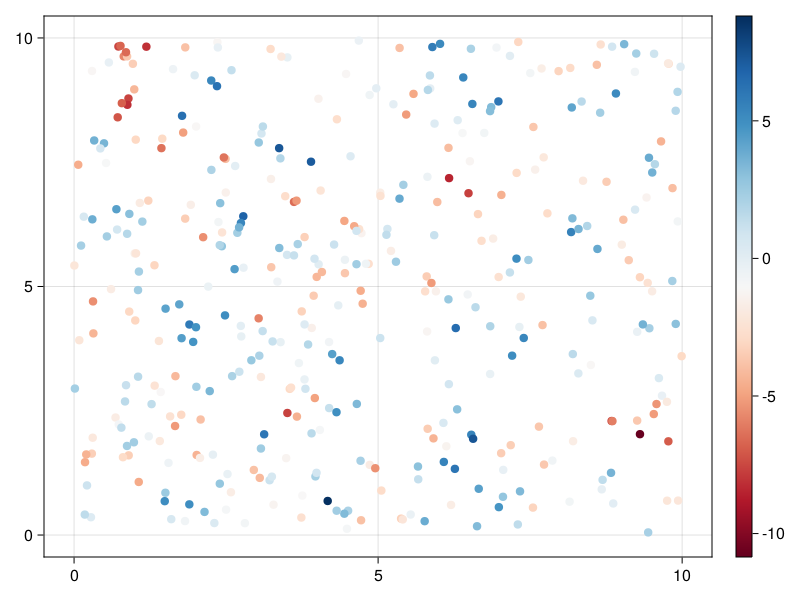

In [5]:
sdf = meshdata(S, etable = (y = rand(Y),))
fig = vis(sdf, variable = :y, colorscheme = :RdBu)

Remember that we can evaluate the log-likelihood function using the `logpdf` function.

In [6]:
logpdf(Y, sdf.y)

-974.5569560863948

### Estimate parameters

#### Define negative log-likelihood function

The loss function should take parameters that belongs to the real line. For this reason
with can define $\theta_1 = log(\sigma^2)$ and $\theta_2 = log(\phi)$ such as the
optimization will be done with respect to $\theta$.

In [7]:
function loss_function(s, y)
    function negativelogmarginallikelihood(params)
        k = exp(params[1]) * Matern32Kernel() ∘ ScaleTransform(1 / exp(params[2]))
        W = GP(k)
        Y = W(coordinates.(s), 1)
        return -logpdf(Y, y)
    end
    return negativelogmarginallikelihood
end

loss_function (generic function with 1 method)

#### Optimize

We can start with reasonable values.

In [8]:
θ0 = log.([var(sdf.y), 0.5])
# θ0 = randn(2)
@time opt = Optim.optimize(loss_function(domain(sdf), sdf.y), θ0, LBFGS())
estimate = exp.(opt.minimizer)

  0.375921 seconds (65.66 k allocations: 955.154 MiB, 20.08% gc time)


2-element Vector{Float64}:
 10.857755077256499
  0.3444999623600113

The maximum value of the log-likelihood function is

In [9]:
- loss_function(domain(sdf), sdf.y)(opt.minimizer)

-973.3304823081519

#### Spatial prediction

First we need to define the set of locations where prediction is desired.

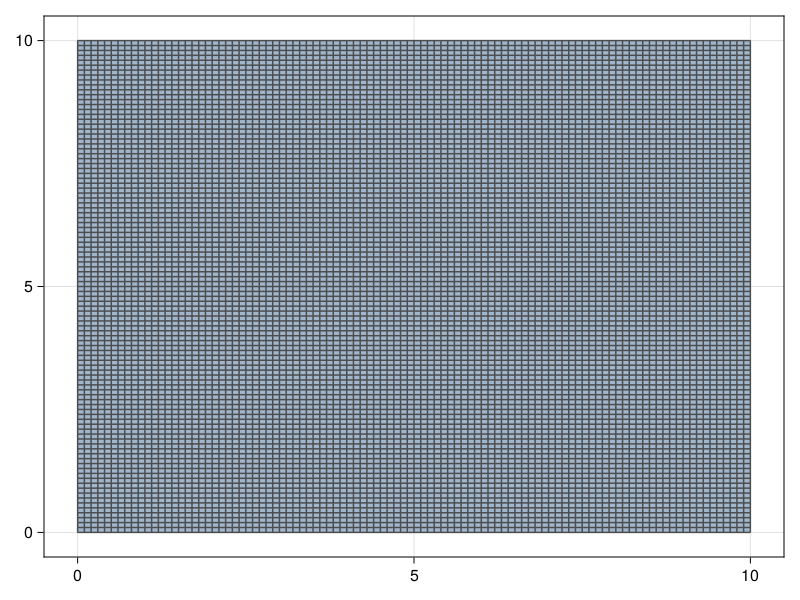

In [10]:
G = CartesianGrid((0,0), (10,10), dims = (100, 100))
fig = viz(G, showfacets = true)

Lets define a GP with the estimates obtained.

In [11]:
W = GP(estimate[1] * Matern32Kernel() ∘ ScaleTransform(1 / exp(estimate[2])))
Ws = W(coordinates.(domain(sdf)), 1)

AbstractGPs.FiniteGP{AbstractGPs.GP{AbstractGPs.ZeroMean{Float64}, KernelFunctions.TransformedKernel{KernelFunctions.ScaledKernel{KernelFunctions.Matern32Kernel{Distances.Euclidean}, Float64}, KernelFunctions.ScaleTransform{Float64}}}, Vector{Meshes.Vec2}, LinearAlgebra.Diagonal{Int64, FillArrays.Fill{Int64, 1, Tuple{Base.OneTo{Int64}}}}}(
f: AbstractGPs.GP{AbstractGPs.ZeroMean{Float64}, KernelFunctions.TransformedKernel{KernelFunctions.ScaledKernel{KernelFunctions.Matern32Kernel{Distances.Euclidean}, Float64}, KernelFunctions.ScaleTransform{Float64}}}(AbstractGPs.ZeroMean{Float64}(), Matern 3/2 Kernel (metric = Distances.Euclidean(0.0))
	- σ² = 10.857755077256499
	- Scale Transform (s = 0.7085745788575731))
x: Meshes.Vec2[[2.490963157151298, 7.56757202075031], [0.27776323141746606, 0.35793046087259855], [4.32279474279457, 8.363669104573678], [4.506727976453759, 0.48907305306337134], [6.627187980496638, 0.1769482114431109], [1.6612611854092663, 2.1928675963166744], [7.704047221359884, 

Define the random vector for prediction

In [12]:
Ws_pred = posterior(Ws, sdf.y)
Wg = Ws_pred(coordinates.(centroid.(G)))
datapred = meshdata(G, etable = (μ = mean(Wg), σ² = var(Wg)))

100×100 CartesianGrid{2,Float64}
  variables (rank 2)
    └─μ (Float64)
    └─σ² (Float64)

Visualize the mean of the prediction.

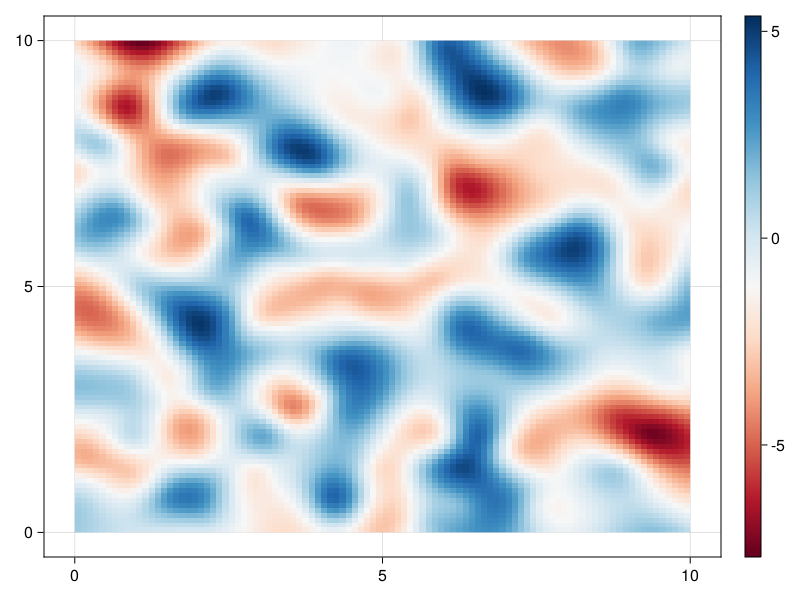

In [13]:
fig = vis(datapred, variable = :μ, colorscheme = :RdBu)

Visualize the variance of the prediction.

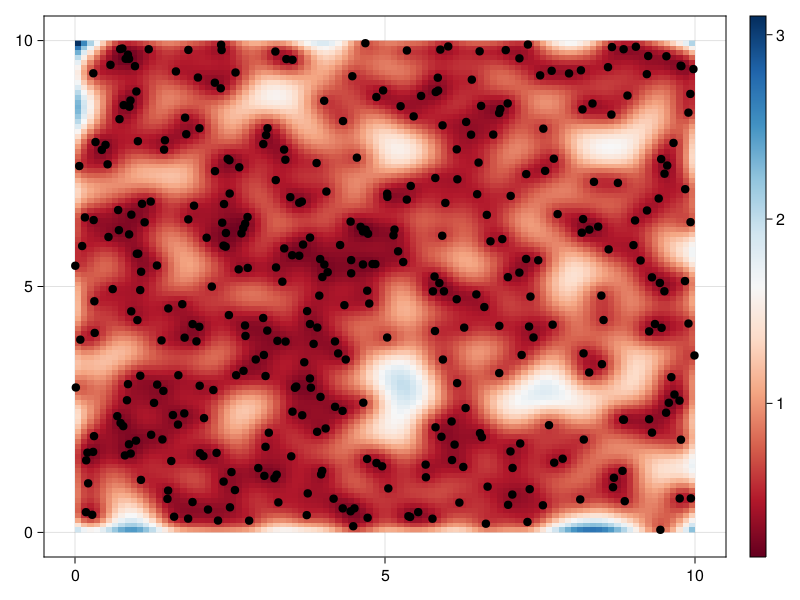

In [14]:
fig = vis(datapred, variable = :σ², colorscheme = :RdBu)
viz!(domain(sdf), color = :black, size = 8)
fig

Compare observed with predicted mean.

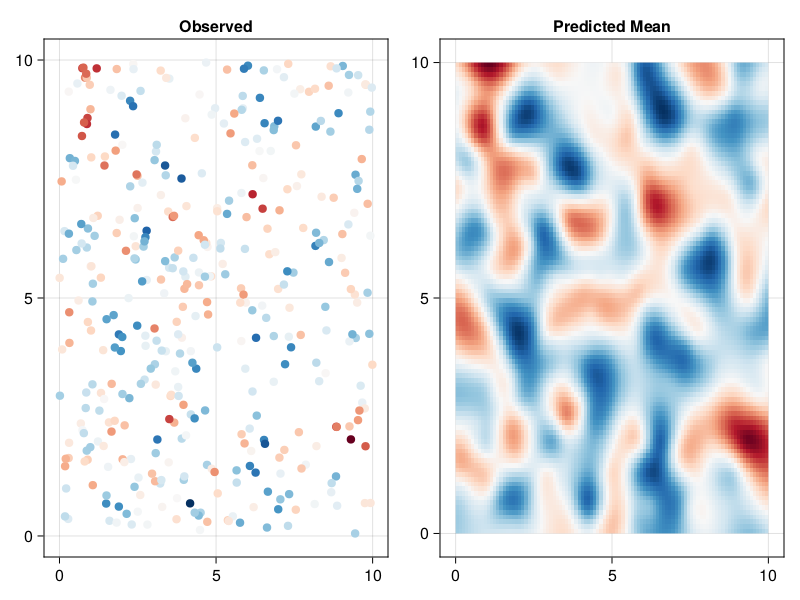

In [15]:
fig = Figure()
Axis(fig[1, 1], title = "Observed")
viz!(sdf.geometry, color = sdf.y, colorscheme = :RdBu)
Axis(fig[1, 2], title = "Predicted Mean")
viz!(datapred.geometry, color = datapred.μ, colorscheme = :RdBu)
fig

## Spatial Gaussian Processes: Inference and prediction

### Loading main packages

In [16]:
import CairoMakie: save, Figure, Axis
using Meshes, MeshViz
using AbstractGPs
using StatsFuns
using Optim

### Simulating spatial GPs

Define the Gaussian process with $\sigma^2 = 10 and \phi = 0.3$.

In [17]:
κ = 10 * Matern32Kernel() ∘ ScaleTransform(1 / 0.3)
W = GP(κ)

AbstractGPs.GP{AbstractGPs.ZeroMean{Float64}, KernelFunctions.TransformedKernel{KernelFunctions.ScaledKernel{KernelFunctions.Matern32Kernel{Distances.Euclidean}, Int64}, KernelFunctions.ScaleTransform{Float64}}}(AbstractGPs.ZeroMean{Float64}(), Matern 3/2 Kernel (metric = Distances.Euclidean(0.0))
	- σ² = 10
	- Scale Transform (s = 3.3333333333333335))

Define a number of location where observations are taken.

In [18]:
n = 400
D = Quadrangle((0, 0), (10, 0), (10, 10), (0, 10))
S = sample(D, HomogeneousSampling(n)) |> PointSet

400 PointSet{2,Float64}
  └─Point(5.624130723878128, 9.50007726080846)
  └─Point(2.1514487905649213, 0.7577294804190493)
  └─Point(8.79333370844927, 8.31440277065897)
  └─Point(4.332924937747884, 5.7568974348852535)
  └─Point(9.504881583267615, 0.2888993652294469)
  ⋮
  └─Point(0.2955522769273278, 9.816665117704087)
  └─Point(2.4417500409358706, 0.8775757530095862)
  └─Point(5.674079870611919, 1.6408742097864149)
  └─Point(2.521292759584899, 1.1350362882831433)
  └─Point(2.3122074675353046, 1.5463811474562605)

Define the random vector with respect of the locations and and error term with $\tau^2 = 1$.

In [19]:
W_s = W(coordinates.(S), 1)

AbstractGPs.FiniteGP{AbstractGPs.GP{AbstractGPs.ZeroMean{Float64}, KernelFunctions.TransformedKernel{KernelFunctions.ScaledKernel{KernelFunctions.Matern32Kernel{Distances.Euclidean}, Int64}, KernelFunctions.ScaleTransform{Float64}}}, Vector{Meshes.Vec2}, LinearAlgebra.Diagonal{Int64, FillArrays.Fill{Int64, 1, Tuple{Base.OneTo{Int64}}}}}(
f: AbstractGPs.GP{AbstractGPs.ZeroMean{Float64}, KernelFunctions.TransformedKernel{KernelFunctions.ScaledKernel{KernelFunctions.Matern32Kernel{Distances.Euclidean}, Int64}, KernelFunctions.ScaleTransform{Float64}}}(AbstractGPs.ZeroMean{Float64}(), Matern 3/2 Kernel (metric = Distances.Euclidean(0.0))
	- σ² = 10
	- Scale Transform (s = 3.3333333333333335))
x: Meshes.Vec2[[5.624130723878128, 9.50007726080846], [2.1514487905649213, 0.7577294804190493], [8.79333370844927, 8.31440277065897], [4.332924937747884, 5.7568974348852535], [9.504881583267615, 0.2888993652294469], [3.9725993596933282, 1.381267046410034], [0.23380337181333588, 0.261787989733161], [4.

Add the effect of a predictor.

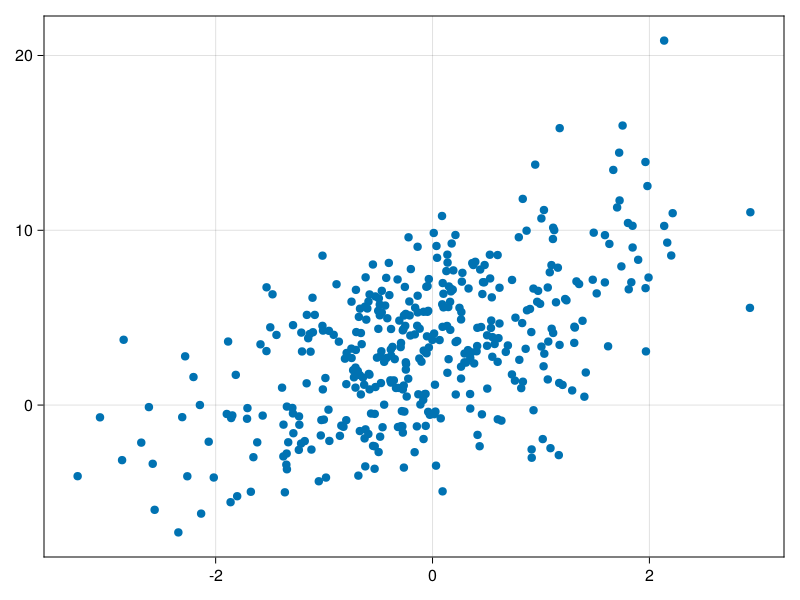

In [20]:
x = randn(length(S))
y = 3 .+ 2 * x + rand(W_s)
fig = CairoMakie.scatter(x, y)

Define the spatial dataset.

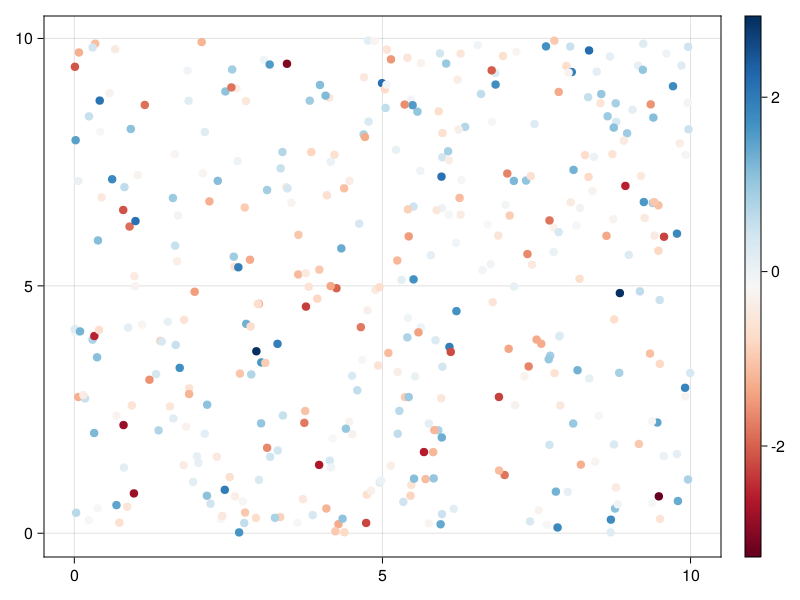

In [21]:
sdf = meshdata(S, etable = (y = y, x = x))
fig = vis(sdf, variable = :x,  colorscheme = :RdBu)

### Estimate parameters

#### Define negative log-likelihood function

The loss function should take parameters that belongs to the real line. For this reason
with can define $\theta_1 = log(\sigma^2)$ and $\theta_2 = log(\phi)$ such as the
optimization will be done with respect to $\theta$.

In [22]:
function loss_function(s, y, x)
    function negativelogmarginallikelihood(params)
        k = exp(params[1]) * Matern32Kernel() ∘ ScaleTransform(1 / exp(params[2]))
        W = GP(k)
        Ws = W(coordinates.(s), 1)
        return -logpdf(Ws, y .- params[3] - params[4] * x)
    end
    return negativelogmarginallikelihood
end

loss_function (generic function with 2 methods)

#### Optimize

We can start with reasonable values.

In [23]:
θ0 = [log(var(sdf.y - 2 * sdf.x)), log(0.5), 0, 0]
# θ0 = randn(2)
@time opt = Optim.optimize(loss_function(domain(sdf), sdf.y, sdf.x), θ0, LBFGS())
estimate = [exp(opt.minimizer[1]), exp(opt.minimizer[2]),
    opt.minimizer[3], opt.minimizer[4]]

  1.002061 seconds (79.39 k allocations: 3.029 GiB, 15.21% gc time)


4-element Vector{Float64}:
 10.618338368422254
  0.32697930352286747
  3.7053735495338267
  2.143959013358795

The maximum value of the log-likelihood function is

In [24]:
- loss_function(domain(sdf), sdf.y, sdf.x)(opt.minimizer)

-979.746496206482

#### Spatial prediction

First we need to define the set of locations where prediction is desired and where the
predictor is available.

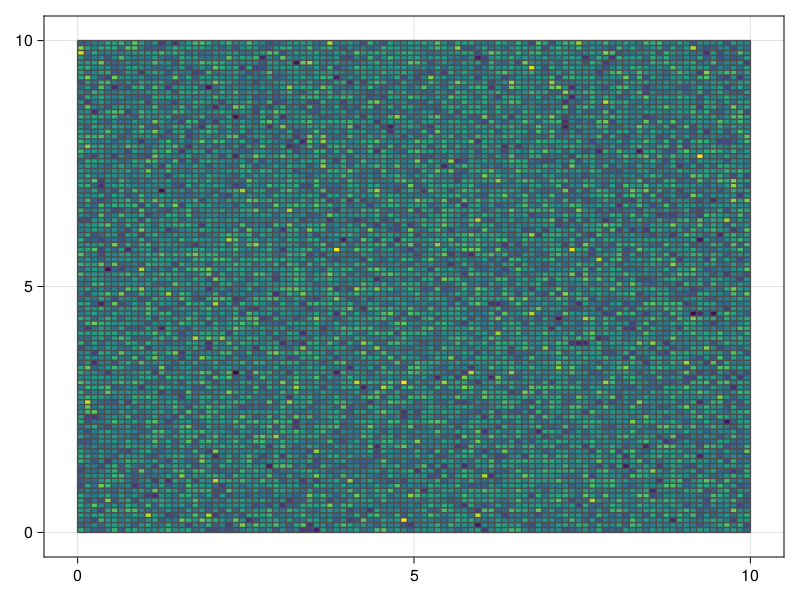

In [25]:
G = CartesianGrid((0,0), (10,10), dims = (100, 100))
datapred = meshdata(G, etable = (x = randn(10000),))
fig = vis(datapred, variable = :x, showfacets = true)

Lets define a GP with the estimates obtained.

In [26]:
W = GP(estimate[1] * Matern32Kernel() ∘ ScaleTransform(1 / exp(estimate[2])))
Ws = W(coordinates.(domain(sdf)), 1)

AbstractGPs.FiniteGP{AbstractGPs.GP{AbstractGPs.ZeroMean{Float64}, KernelFunctions.TransformedKernel{KernelFunctions.ScaledKernel{KernelFunctions.Matern32Kernel{Distances.Euclidean}, Float64}, KernelFunctions.ScaleTransform{Float64}}}, Vector{Meshes.Vec2}, LinearAlgebra.Diagonal{Int64, FillArrays.Fill{Int64, 1, Tuple{Base.OneTo{Int64}}}}}(
f: AbstractGPs.GP{AbstractGPs.ZeroMean{Float64}, KernelFunctions.TransformedKernel{KernelFunctions.ScaledKernel{KernelFunctions.Matern32Kernel{Distances.Euclidean}, Float64}, KernelFunctions.ScaleTransform{Float64}}}(AbstractGPs.ZeroMean{Float64}(), Matern 3/2 Kernel (metric = Distances.Euclidean(0.0))
	- σ² = 10.618338368422254
	- Scale Transform (s = 0.7210986670742422))
x: Meshes.Vec2[[5.624130723878128, 9.50007726080846], [2.1514487905649213, 0.7577294804190493], [8.79333370844927, 8.31440277065897], [4.332924937747884, 5.7568974348852535], [9.504881583267615, 0.2888993652294469], [3.9725993596933282, 1.381267046410034], [0.23380337181333588, 0.2

Define the random vector for prediction

In [27]:
Ws_pred = posterior(Ws, sdf.y .- estimate[3] - estimate[4] * sdf.x)
Wg = Ws_pred(coordinates.(centroid.(G)))
datapred = meshdata(G, etable = (x = datapred.x, μ = mean(Wg), σ² = var(Wg),
    μ_y = mean(Wg) .+ estimate[3] + estimate[4] * datapred.x))

100×100 CartesianGrid{2,Float64}
  variables (rank 2)
    └─x (Float64)
    └─μ (Float64)
    └─σ² (Float64)
    └─μ_y (Float64)

Visualize the mean of the prediction of W.

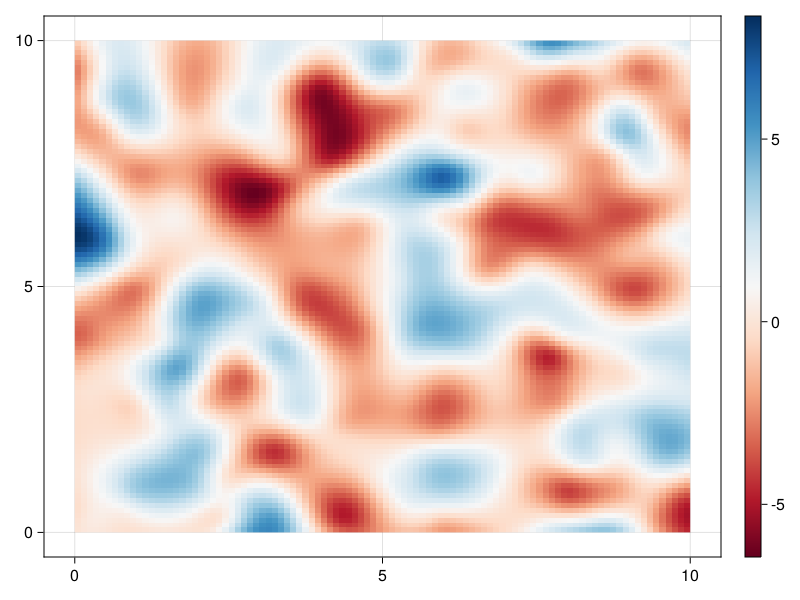

In [28]:
fig = vis(datapred, variable = :μ, colorscheme = :RdBu)

Visualize the mean of the prediction of Y.

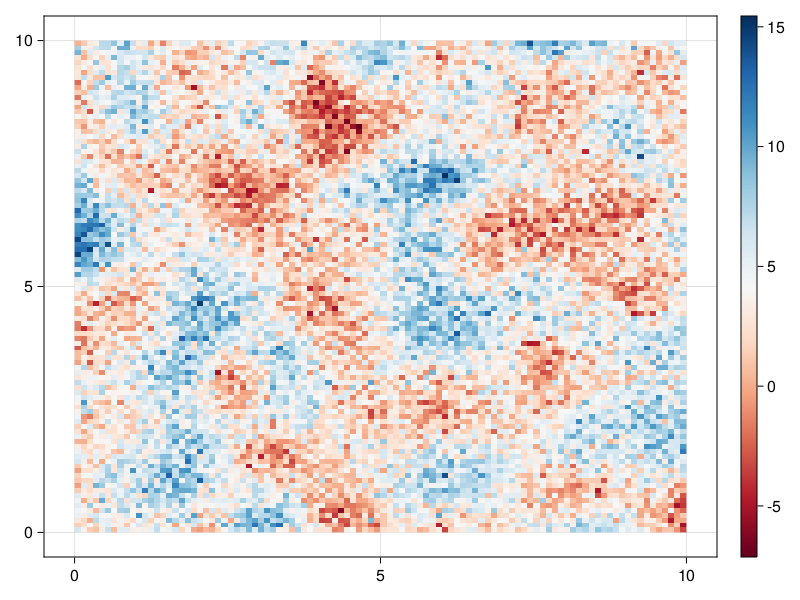

In [29]:
fig = vis(datapred, variable = :μ_y, colorscheme = :RdBu)

Visualize the variance of the prediction.

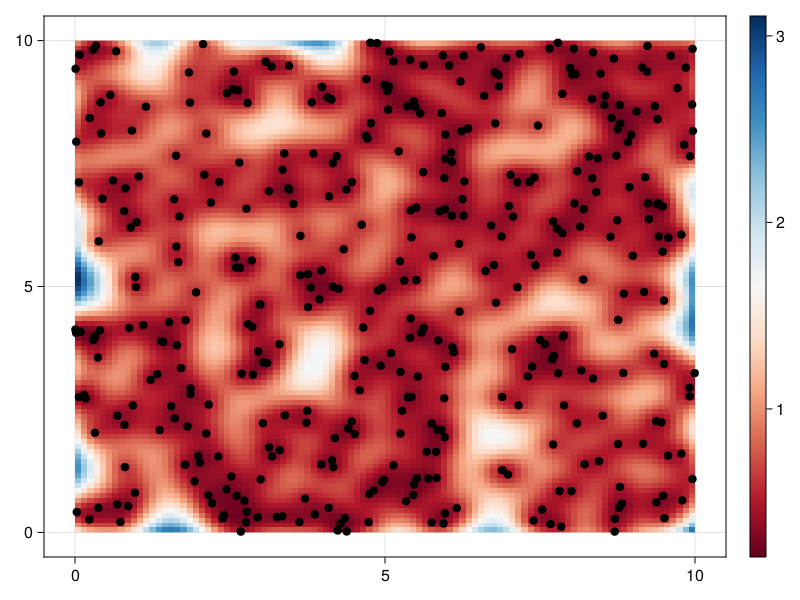

In [30]:
fig = vis(datapred, variable = :σ², colorscheme = :RdBu)
viz!(domain(sdf), color = :black, size = 8)
fig

Compare observed with predicted mean.

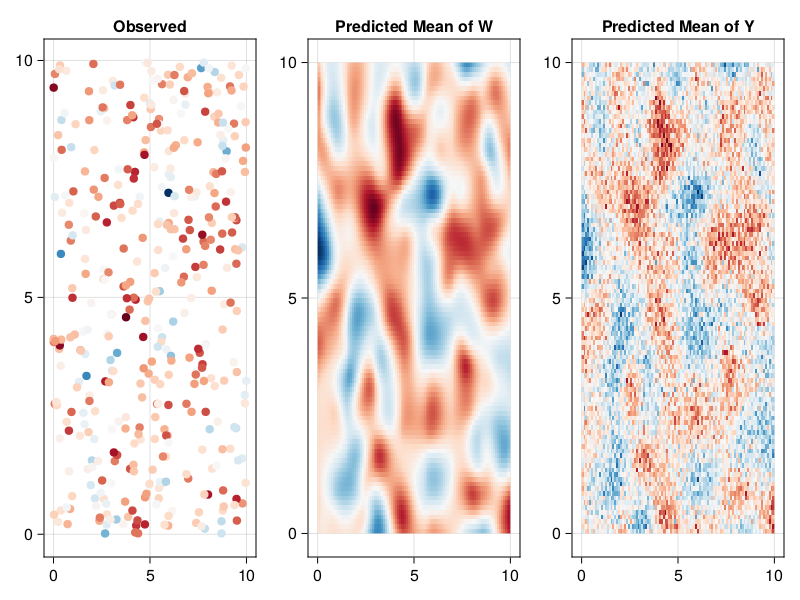

In [31]:
fig = Figure()
Axis(fig[1, 1], title = "Observed")
viz!(sdf.geometry, color = sdf.y, colorscheme = :RdBu)
Axis(fig[1, 2], title = "Predicted Mean of W")
viz!(datapred.geometry, color = datapred.μ, colorscheme = :RdBu)
Axis(fig[1, 3], title = "Predicted Mean of Y")
viz!(datapred.geometry, color = datapred.μ_y, colorscheme = :RdBu)
fig

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*